# PyTorch Adavnce Usage 

Hello readers, this is yet another post in a series we are doing PyTorch. This post is aimed for PyTorch users who are familiar with basics of PyTorch and would like to move to an intermediate level. While we have covered how to implement a basic classifier in an earlier post, in this post, we will be discussing how to implement more complex deep learning functionality using PyTorch. Some of the objectives of this posts are to make you understand. 

1. What is the difference between PyTorch classes like `nn.Module`, `nn.Functional` and when to use which
2. How to customise your training options such as different learning rates for different layers, weight initialisation etc. 
3. How to use Tensorboard with PyTorch.
4. How to visualise the computation graph and print it's intermediate values for debugging.  

So, let's get started. 


## nn.Module vs nn.Functional

This is something that comes quite a lot especially when you are reading open source code. In PyTorch, layers are often implemented as either one of `torch.nn.Module` objects or `torch.nn.Functional` functions. Which one to use? Which is better? 

As we had covered in Part 2, `torch.nn.Module` is basically the cornernstone of PyTorch. The way it works is you first define an `nn.Module` object,  and then invoke it's `forward` method to run it. This is a Object Oriented way of doing things. 

On the other hand, `nn.functional` provides some layers / activations in form of functions that can be directly called on the input rather than defining the an object. For example, in order to rescale an image tensor, you call `torch.nn.functional.interpolate` on an image tensor.








In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

inp = torch.randn(1,3,64,64)     # random input image

# Same thing using two approaches
# ---------------------------------------

# torch.nn
avg_pool = nn.AvgPool2d(4)     # create an object
nn_out = avg_pool(inp)         # invoke the forward method

# torch.nn.Functional
f_out = F.avg_pool2d(inp, 4)


print (torch.equal(nn_out, f_out))        # check whether the same result is produced

True


So how do we choose what to use when? When the layer / activation / loss we are implementing has a loss. 

### Understanding Stateful-ness

Normally, any layer can be seen as a function. For example, a convolutional operation is just a bunch of multiplication and addition operations. So, it makes sense for us to just implement it as a function right? But wait, the layer holds weights which need to be stored and updated while we are training. Therefore, from a programmatical angle, a layer is more than function. It also needs to hold data, which changes as we train our network. 

I now want to you to stress upon that fact that the data held by the convolutional layer **changes**. This means that the layer has a *state* which changes as we train. For us to implement a function that does the convolutional operation, we would also need to define a data structure to hold the weights of the layer seperately from the function itself. And then, make this external data structure an input to our function. 

Or just to beat the hassle, we could just define a class to hold the data structure, and make convolutional operation as an member function. This would really ease up our job, as we don't have to worry about stateful variables existing outside of the function. In these cases, we would prefer to use the `nn.Module` objects where we have weights or other states which might define the behaviour of the layer. For example, a dropout / Batch Norm layer behaves differently during training and inference. 

On the other hand, where no state or weights are required, one could use the `nn.functional`. Examples being, resizing (`nn.functional.interpolate`),  average pooling (`nn.functional.AvgPool2d`). 

Despite the above reasoning, most of the `nn.Module` classes have their `nn.functional` counterparts. However, the above line of reasoning is to be respected during practical work. 


## nn.Parameter

An important class in PyTorch is the `nn.Parameter` class, which to my surprise, has gotten little coverage in PyTorch introductory texts. Consider the following case. 

In [2]:
class net(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv = nn.Linear(10,5)
    
  def forward(self, x):
    return self.linear(x)


myNet = net()
print(list(myNet.parameters()))

[Parameter containing:
tensor([[ 0.1846,  0.0970,  0.2853, -0.0155,  0.0444,  0.0111, -0.2379,  0.3031,
         -0.0066, -0.3082],
        [-0.0597,  0.3029,  0.1465, -0.1953, -0.0772,  0.2787,  0.0993,  0.1490,
          0.1092,  0.2071],
        [-0.0020, -0.0827, -0.0210, -0.2498, -0.2665, -0.0401,  0.1341,  0.2261,
          0.1353, -0.0535],
        [ 0.2528, -0.2944,  0.2399,  0.0518, -0.1557,  0.3133,  0.2751,  0.1018,
          0.0560, -0.0129],
        [ 0.2143,  0.1001, -0.2193,  0.2649, -0.1005,  0.2521, -0.0974, -0.3137,
          0.3014, -0.0938]], requires_grad=True), Parameter containing:
tensor([-0.1840,  0.2230,  0.0539, -0.2962,  0.2762], requires_grad=True)]


Each `nn.Module` has a `parameters()` function which returns, well, it's trainable parameters. We have to implicitly define what these parameters are. In definition of `nn.Conv2d`, the authors of PyTorch defined the parameters to that of a layer. However, notice on thing, that when we defined `net`, we didn't need to add the `parameters` of `nn.Conv2d` to `parameters` of `net`. It happened implicitly by virtue of setting `nn.Conv2d` object as a memeber of the `net` object. 


This is internally faciliated by the `nn.Parameter` class, which subclasses the `Tensor` class. When we invoke `parameters()` function of a `nn.Module` object, it returns all it's members which are `nn.Parameter` objects. 

Infact, all the training weights of `nn.Module` classes are implemented as `nn.Parameter` objects. Whenever, a `nn.Module` (`nn.Conv2d` in our case) is assigned as a member of another `nn.Module`, the "parameters" of the assignee object (i.e. the weights of `nn.Conv2d`) are also added the "parameters" of the object which is beeng assigned to (parameters of `net` object). This is called registering "parameters" of a `nn.Module`

If you try to assign a tensor to the `nn.Module` object, it won't show up in the `parameters()` unless you define it as `nn.Parameter` object. This has been done to facilitate scenarios where you might need to cache a non-differentiable tensor,  example in case,  caching previous output in case of RNNs. 

In [3]:
class net1(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv = nn.Linear(10,5)
    self.tens = torch.ones(3,4)                       # This won't show up in a parameter list 
    
  def forward(self, x):
    return self.linear(x)


myNet = net1()
print(list(myNet.parameters()))

[Parameter containing:
tensor([[-0.0494, -0.1193, -0.2282, -0.1652, -0.0605, -0.0831,  0.0609, -0.0288,
         -0.1870,  0.1633],
        [ 0.0578, -0.1171, -0.1310,  0.3141,  0.2610, -0.0521,  0.2128,  0.0202,
          0.0022, -0.1664],
        [-0.2865,  0.0735, -0.0360,  0.1419,  0.2823,  0.1375, -0.1025,  0.0339,
          0.1438, -0.0067],
        [ 0.2777, -0.2733,  0.0601, -0.2115, -0.2909,  0.1398, -0.1229, -0.2810,
          0.2425,  0.2586],
        [ 0.2198, -0.2501, -0.1739, -0.1049, -0.0087,  0.0969, -0.0273, -0.2518,
         -0.2899,  0.2574]], requires_grad=True), Parameter containing:
tensor([ 0.2200, -0.2819, -0.2864,  0.1680,  0.1531], requires_grad=True)]


In [4]:
class net2(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv = nn.Linear(10,5) 
    self.tens = nn.Parameter(torch.ones(3,4))                       # This will show up in a parameter list 
    
  def forward(self, x):
    return self.linear(x)


myNet = net2()
print(list(myNet.parameters()))

[Parameter containing:
tensor([[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]], requires_grad=True), Parameter containing:
tensor([[ 0.2822, -0.2529, -0.2258,  0.2095, -0.1306, -0.1231,  0.2388, -0.0766,
          0.1691,  0.1905],
        [ 0.0399, -0.2092, -0.1827,  0.2246,  0.2999, -0.2866,  0.2838,  0.0032,
         -0.0297,  0.0120],
        [ 0.0992, -0.2248, -0.1378, -0.2271, -0.1378, -0.1859, -0.1138,  0.0954,
         -0.2970,  0.1850],
        [ 0.0490,  0.0403, -0.1714,  0.3115,  0.0583, -0.0978,  0.0268,  0.2462,
         -0.0775, -0.3157],
        [-0.2351,  0.3097, -0.1333, -0.2439,  0.1744, -0.1694, -0.1920, -0.2379,
         -0.0764, -0.2017]], requires_grad=True), Parameter containing:
tensor([-0.2704,  0.1900, -0.1803,  0.2859,  0.1204], requires_grad=True)]


In [5]:
class net3(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv = nn.Linear(10,5) 
    self.net  = net2()                      # Parameters of net2 will show up in list of parameters of net3
    
  def forward(self, x):
    return self.linear(x)


myNet = net3()
print(list(myNet.parameters()))

[Parameter containing:
tensor([[-0.1766, -0.2913,  0.0239, -0.2141, -0.1376, -0.0114, -0.1342, -0.1564,
          0.1679, -0.2835],
        [-0.2454,  0.2568, -0.0689,  0.1794,  0.1163, -0.2717,  0.2153, -0.1286,
         -0.3019,  0.0099],
        [-0.2485,  0.0370,  0.2365,  0.1740, -0.0854,  0.1632,  0.2836, -0.3125,
          0.1529,  0.2212],
        [ 0.1464,  0.3054, -0.1252,  0.0500, -0.2272, -0.1021, -0.0869, -0.0862,
         -0.0060,  0.0478],
        [-0.2726, -0.1273, -0.0293,  0.0069, -0.1914, -0.1478,  0.1430,  0.3047,
          0.2626,  0.2579]], requires_grad=True), Parameter containing:
tensor([-0.0170, -0.0150, -0.1105, -0.2139,  0.1391], requires_grad=True), Parameter containing:
tensor([[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]], requires_grad=True), Parameter containing:
tensor([[-0.2596,  0.0676,  0.0063,  0.3053,  0.1257, -0.0531,  0.2886,  0.3121,
          0.2968, -0.0409],
        [ 0.0509,  0.1206, -0.2226, -0.2056,  0.0236,  0.101

### nn.ModuleList and nn.ParameterList()

I remember I had to you a `nn.ModuleList` when I was implementing YOLO v3 in PyTorch. I had to create the network by parsing a text file which contained the architecture. I stored all the `nn.Module` objects corresponding in a Python list and then made the list a member of my `nn.Module` object representing the network.  

To simplify it, something like this. 

In [6]:
layer_list = [nn.Conv2d(5,5,3), nn.BatchNorm2d(5), nn.Linear(5,2)]

class myNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.layers = layer_list
  
  def forward(x):
    for layer in self.layers:
      x = layer(x)

net = myNet()

print(list(net.parameters())) 

[]


As you see, unlike when we would register individual modules, assigning a Python List doesn't register the parameters of Modules inside the list. To fix this, we wrap our list with the `nn.ModuleList` class, and then assign it as a member of the network class. 

In [7]:
layer_list = [nn.Conv2d(5,5,3), nn.BatchNorm2d(5), nn.Linear(5,2)]

class myNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.layers = nn.ModuleList(layer_list)
  
  def forward(x):
    for layer in self.layers:
      x = layer(x)

net = myNet()

print(list(net.parameters())) 

[Parameter containing:
tensor([[[[-1.4344e-01,  1.3879e-01,  3.4137e-02],
          [-2.4901e-02, -1.1976e-01,  7.0103e-02],
          [ 8.4627e-02, -1.1385e-01, -1.1483e-01]],

         [[-2.7231e-02, -1.0273e-01,  1.2866e-01],
          [ 4.9336e-04,  7.4797e-02,  1.4066e-01],
          [ 2.1796e-02, -1.0067e-01, -1.8363e-02]],

         [[ 4.3644e-02, -3.5372e-02,  6.2309e-02],
          [ 6.4128e-02,  1.0099e-01,  6.6372e-02],
          [-1.2661e-02,  2.9149e-03,  1.0361e-01]],

         [[ 1.2332e-01, -9.6792e-03,  1.4889e-01],
          [ 1.0564e-01,  1.8913e-02, -8.1076e-02],
          [ 1.2256e-01, -8.3358e-02, -1.0419e-01]],

         [[ 1.1769e-01,  1.0935e-01,  1.2643e-01],
          [ 1.0030e-01, -3.0156e-02,  5.3058e-02],
          [-5.6571e-02,  1.0527e-01, -2.8197e-02]]],


        [[[-7.1571e-02,  1.0665e-01,  1.1227e-02],
          [-8.9246e-02,  1.3762e-01,  8.4198e-02],
          [-2.2030e-03, -1.4803e-01,  5.6313e-02]],

         [[-1.4160e-01,  6.9753e-02, -9.0819e

Similarly, a list of tensors can be registered by wrapping the list inside a `nn.ParameterList` class. 

## Weight Initialisation

Weight initialisation can influence the results of your training. What's more, you may require different weight initialisation schemes for different sort of layers. This can be accomplished by the `modules` and `apply functions. `modules` is a member function of `nn.Module` class which returns an iterator containing all the memeber `nn.Module` objects of a `nn.Module` function. Then `apply`  unction can be called on each  nn.Module`  to set it's initialisation. 



Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], requires_grad=True)


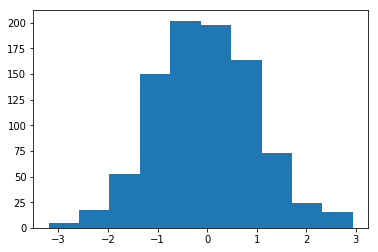

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

class myNet(nn.Module):
 
  def __init__(self):
    super().__init__()
    self.conv = nn.Conv2d(10,10,3)
    self.bn = nn.BatchNorm2d(10)
  
  def weights_init(self):
    for module in self.modules():
      if isinstance(module, nn.Conv2d):
        nn.init.normal_(module.weight, mean = 0, std = 1)
        nn.init.constant_(module.bias, 0)

Net = myNet()
Net.weights_init()

for module in Net.modules():
  if isinstance(module, nn.Conv2d):
    weights = module.weight
    weights = weights.reshape(-1).detach().cpu().numpy()
    print(module.bias)                                       # Bias to zero
    plt.hist(weights)
    plt.show()
    
  

There are a plethora of inplace initialisation functions to be found in the `torch..nn.init` module. 

### modules() vs children()

A very similar function to `modules` is `children`. The difference is a slight but an important one. As we know, a `nn.Module` object can contain other `nn.Module` objects as it's data members. `children()` will only return an iterable of the `nn.Module` objects which are data members.

On other hand, `nn.Modules` goes recursively inside each `nn.Module` object, printing each `nn.Module` object that comes along the way until there are no `nn.module` objects left. 

Note, that the above statement remains true for all objects / classes that subclass from `nn.Module` class.

In [9]:
class myNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.convBN =  nn.Sequential(nn.Conv2d(10,10,3), nn.BatchNorm2d(10))
    self.linear =  nn.Linear(10,2)
    
  def forward(self, x):
    pass
  

Net = myNet()

print("Printing children\n------------------------------")
print(list(Net.children()))
print("\n\nPrinting Modules\n------------------------------")
print(list(Net.modules()))




Printing children
------------------------------
[Sequential(
  (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
  (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
), Linear(in_features=10, out_features=2, bias=True)]


Printing Modules
------------------------------
[myNet(
  (convBN): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (linear): Linear(in_features=10, out_features=2, bias=True)
), Sequential(
  (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
  (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
), Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1)), BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), Linear(in_features=10, out_features=2, bias=True)]


So, when we initiase the weights, we must use `modules()` function since we can't go inside the `nn.Sequential` object and initialise the weight for it's members.

## Printing Information About the Network

We may need to print information about the network, whether be it for the user or for debugging purposes. PyTorch provides a really neat way to print a lot of information about out network using it's `named_*` functions. There are 4 such functions. 

1. `named_parameters`. Returns an iterator which gives a tuple containing **name** of the parameters (if a convolutional layer is assigned as `self.conv1`, then it's parameters would be `conv1.weight` and `conv1.bias`) and the value returned by the `__repr__` function of the `nn.Parameter`

2. `named_modules`. Same as above, but iterator returns modules like `modules()` function does. 
3. `named_children` Same as above, but iterator return modules like `children()` returns
4. `named_buffers` Return buffer tensors such as running mean average of a Batch Norm layer. 



In [10]:
for x in Net.named_modules():
  print(x[0], x[1], "\n-------------------------------")

 myNet(
  (convBN): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (linear): Linear(in_features=10, out_features=2, bias=True)
) 
-------------------------------
convBN Sequential(
  (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
  (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
) 
-------------------------------
convBN.0 Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1)) 
-------------------------------
convBN.1 BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True) 
-------------------------------
linear Linear(in_features=10, out_features=2, bias=True) 
-------------------------------


## Different Learning Rates for Different Layers

In the last section, we will learn how to use different learning rates for different learning rates for our different layers. In general, we will cover how to have different hyperparameters for different groups of parameters, whether it be different learning rate for different layers, or different learning rate for biases and weights. 

The idea to implement such a thing is fairly simple. In our previous post, where we implemented a CIFAR classifier, we passed all the parameters of network as a whole to the optimiser object. 


In [0]:
class myNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(10,5)
    self.fc2 = nn.Linear(5,2)
    
  def forward(self, x):
    return self.fc2(self.fc1(x))

Net = myNet()
optimiser = torch.optim.SGD(Net.parameters(), lr = 0.5)


      

However, the `torch.optim` class allows us to provide different sets of parameters having different learning rates in form of a dictionary.




In [0]:
optimiser = torch.optim.SGD([{"params": Net.fc1.parameters(), 'lr' : 0.001, "momentum" : 0.99},
                             {"params": Net.fc2.parameters()}], lr = 0.01, momentum = 0.9)

In the above scenario, the parameters of `fc1` use a learning rate of 0.01 and momentum of 0.99. If a hyperparameter is not specified for a group of parameters (like `fc2`), they use the default value of that hyperparameter, given as input argument to the optimiser function. 

In [0]:
params_bias = []
params_wts = []

# seperate the bias and weights parameters
for name, parameter in Net.named_parameters():
  if "bias" in name:
    params_bias.append(parameter)
  elif "weight" in name:
    params_wts.append(parameter)

# Set the optimiser to have different hyperparameters for bias and weights
optimiser = torch.optim.SGD([{"params": params_bias, 'lr' : 0.001, "momentum" : 0.99},
                             {"params": params_wts}], lr = 0.01, momentum = 0.9)

## Scheduling Learning Rates

The schedule your learning rate is going to follow is a major hyperparameter that you want to tune. PyTorch provides support for scheduling learning rates with it's `torch.optim.lr_scheduler` module which has a variety of learning rate schedules. The following example demonstrates one such example. 

In [0]:
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimiser, milestones = [10,20], gamma = 0.1)

The above scheduler, multiplies the learning rate by `gamma` each time when we reach epochs contained in the `milestones`list. In our case, the learning rate is multiplied by 0.1 at the 10nth and the 20nth epoch. You will also have to write the line `scheduler.step` in the loop in your code that goes over the epochs. Generally, training loop is made of two nested loops, where one loop goes over the epochs, and the nested one goes over the batches in that epoch. Make sure you call `scheduler.step` at start of the epoch loop so your learning rate is updated. Be careful not to write it in the batch loop, otherwise your learning rate may be updated at the 10th batch rather than 10nth epoch. 

Also remember that `scheduler.step` is no replacement for `optim.step` and you'll have to call `optim.step` everytime you backprop backwards. (This would be in the "batch" loop)


## Saving your Model

You might wanna save your model for later use for inference, or just might want to create training checkpoints. When it comes to saving models in PyTorch one has two options. 

First is to use `torch.save`. This is equivalent to serialising the entire `nn.Module` object using Pickle. This saves the entire model to disk. You can load this model later in the memory with `torch.load`.

In [15]:
torch.save(Net, "net.pth")

Net = torch.load("net.pth")

print(Net)

myNet(
  (fc1): Linear(in_features=10, out_features=5, bias=True)
  (fc2): Linear(in_features=5, out_features=2, bias=True)
)


/usr/local/lib/python3.6/dist-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type myNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


The above will save the entire model with weights and architecture. If you only need to save the weight, instead of saving the entire model, you can save just the `state_dict` of the model. The `state_dict` is basically a dictionary which maps the p`nn.Parameter` objects of a network to their values. 

In [0]:
for key in Net.state_dict():
  print(key, Net.state_dict()[key])
  
torch.save(Net.state_dict(), "net_state_dict.pth")

Net.load_state_dict(torch.load("net_state_dict.pth"))

fc1.weight tensor([[-0.0133, -0.2878,  0.0503,  0.0744,  0.1310,  0.0947, -0.3033,  0.1492,
          0.0490,  0.0941],
        [-0.0879,  0.2181,  0.0458, -0.2721, -0.0646, -0.2481,  0.1032,  0.2052,
         -0.0165, -0.0800],
        [-0.1940, -0.1277, -0.0104, -0.1482, -0.2348,  0.2273, -0.1213,  0.0237,
          0.1119,  0.3139],
        [ 0.1774,  0.1428,  0.1435,  0.0185,  0.1152, -0.2668, -0.2399, -0.2149,
         -0.3055,  0.2551],
        [ 0.3143, -0.2550, -0.2018, -0.0489,  0.1829,  0.0278,  0.0943, -0.0691,
         -0.0146,  0.2699]])
fc1.bias tensor([-0.1506,  0.2532,  0.2250, -0.1547, -0.2230])
fc2.weight tensor([[-0.2647, -0.2557, -0.2494,  0.0225, -0.3246],
        [-0.4338, -0.0281,  0.1650,  0.0791, -0.4264]])
fc2.bias tensor([-0.0396,  0.2155])


As demonstrated above, one can load an exisiting `state_dict` into a `nn.Module` object. Note that this doesn't involve saving of entire model  but only the parameters. You will have to create the network with layers before you load the state dict. If the network architecture is not exactly the same as the one whose `state_dict` we saved, PyTorch will throw up an error. 

An optimiser object from `torch.optim` also has a `state_dict` object which is used to store the hyperparameters of optimisation algorithms. It can be saved and loaded in a similar way we did above.